In [ ]:
!pip install segmentation-models
!pip install nilearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.3 MB/s eta 0:00:00


In [ ]:
!pip install -U -q segmentation-models
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

In [ ]:
import cv2
import glob
import nilearn
import numpy as np
import nibabel as nib
import nilearn.plotting as nlplt
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import montage
from skimage.transform import rotate
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import random
import pandas as pd

# Segmentation Models
import segmentation_models as sm

# Keras
import tensorflow as tf
import keras
import keras.backend as K
from keras.callbacks import CSVLogger
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers.experimental import preprocessing

np.set_printoptions(precision=3, suppress=True)

2024-02-04 16:49:46.113484: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-04 16:49:46.113617: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-04 16:49:46.234339: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Segmentation Models: using `tf.keras` framework.


In [ ]:
tf.__version__

'2.15.0'

In [ ]:
keras.__version__

'2.15.0'

In [ ]:
TRAINING_DATASET = "/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*"

IMAGE_DIR = glob.glob(TRAINING_DATASET)
CSV_LIST = glob.glob(TRAINING_DATASET + 'csv')
for i in CSV_LIST:
    IMAGE_DIR.remove(i)

IMAGE_DIR.remove(TRAINING_DATASET.replace("*", "") + 'BraTS20_Training_355')
IMAGE_DIR = IMAGE_DIR[0:100]

TRAIN_LIST, VAL_LIST = train_test_split(IMAGE_DIR, test_size=0.2)
TRAIN_LIST, TEST_LIST = train_test_split(TRAIN_LIST, test_size=0.3)

VIEW_IMG_IDX = random.randint(0, len(TRAIN_LIST) - 1)
LIST_DATA = sorted(glob.glob(TRAIN_LIST[VIEW_IMG_IDX] + '/*'))
VIEW_IMAGE = {
    'flair': nib.load(LIST_DATA[0]).get_fdata(),
    't1': nib.load(LIST_DATA[2]).get_fdata(),
    't1ce': nib.load(LIST_DATA[3]).get_fdata(),
    't2': nib.load(LIST_DATA[4]).get_fdata(),
    'mask': nib.load(LIST_DATA[1]).get_fdata()
}

#CURRENT_MODEL = 'resNETUNET'
CURRENT_MODEL = 'EfficientNetB0'
# MODEL = {
#     'simpleUNET': 'simpleUNET.h5',
#     'resNETUNET': 'resnetUNET.h5',
#     'WNET': 'WNET.h5',
#     'UNETVAE': 'UNETVAE.h5',
#     'VGG19': 'VGG19.h5',
#     'InceptionV3': 'InceptionV3.h5',
#     'InceptionResNetV2': 'InceptionResNetV2.h5'
# }
# LOG = {
#     'simpleUNET': 'simpleUNET_training.log',
#     'resNETUNET': 'resnetUNET_training.log',
#     'WNET': 'WNET_training.log',
#     'UNETVAE': 'UNETVAE_training.log',
#     'VGG19': 'VGG19_training.log',
#     'InceptionV3': 'InceptionV3_training.log',
#     'InceptionResNetV2': 'InceptionResnetV2_training.log'
# }

SEGMENT_CLASSES = {
    0: 'NOT tumor',
    1: 'NECROTIC/CORE',
    2: 'EDEMA',
    3: 'ENHANCING'
}
# SAVED_MODEL = {
#     'WNET': '../input/wnetmodel/WNET.h5',
#     'resNETUNET': '../input/resnet-unet-trained-model/resnetUNET.h5',
#     'simpleUNET': '../input/simpleunet/simpleUNet.h5',
#     'VGG19': '../input/vgg19v2/VGG19.h5',
#     'InceptionV3': '../input/inceptionv3/InceptionV3.h5',
#     'InceptionResNetV2': '../input/inceptionresnetv2/InceptionResNetV2.h5'
# }
SLICES_VOL = 100
VOL_START = 22
IMG_SIZE = 128

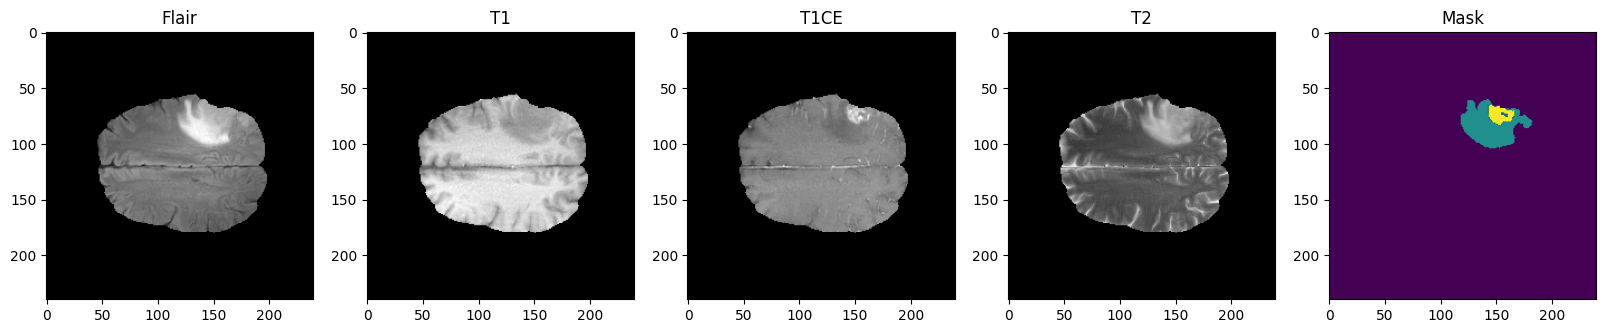

In [ ]:
def analyse_initial_data():
    fig, (axis1, axis2, axis3, axis4, axis5) = plt.subplots(1, 5, figsize=(20, 10))
    slice_w = 25
    axis1.imshow(VIEW_IMAGE['flair'][:, :,
               VIEW_IMAGE['flair'].shape[0]//2 - slice_w], cmap='gray')
    axis1.set_title('Flair')
    axis2.imshow(
        VIEW_IMAGE['t1'][:, :, VIEW_IMAGE['t1'].shape[0]//2 - slice_w], cmap='gray')
    axis2.set_title('T1')
    axis3.imshow(
        VIEW_IMAGE['t1ce'][:, :, VIEW_IMAGE['t1ce'].shape[0]//2 - slice_w], cmap='gray')
    axis3.set_title('T1CE')
    axis4.imshow(
        VIEW_IMAGE['t2'][:, :, VIEW_IMAGE['t2'].shape[0]//2 - slice_w], cmap='gray')
    axis4.set_title('T2')
    axis5.imshow(VIEW_IMAGE['mask']
               [:, :, VIEW_IMAGE['mask'].shape[0]//2 - slice_w])
    axis5.set_title('Mask')


analyse_initial_data()

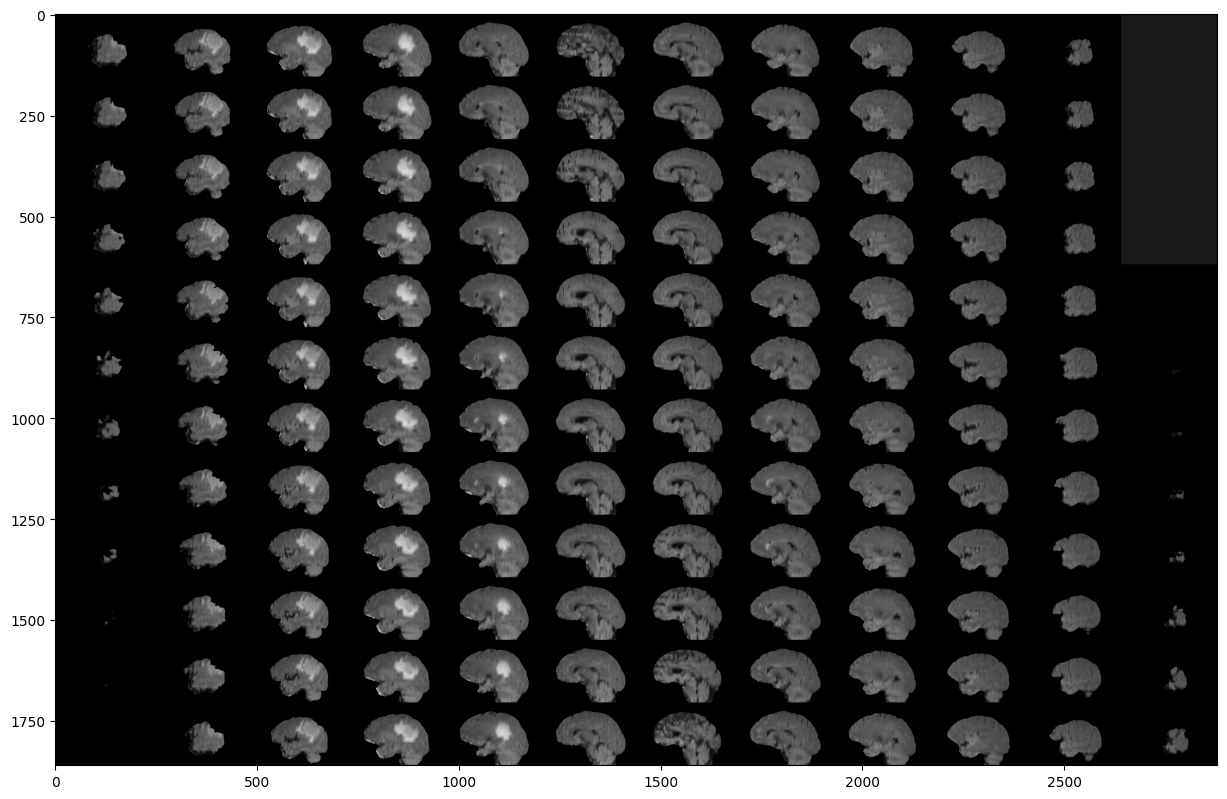

In [ ]:
def show_montage():
    fig, axis = plt.subplots(1, 1, figsize=(15, 15))
    axis.imshow(rotate(
        montage(VIEW_IMAGE['flair'][50:-50, :, :]), 90, resize=True), cmap='gray')


show_montage()

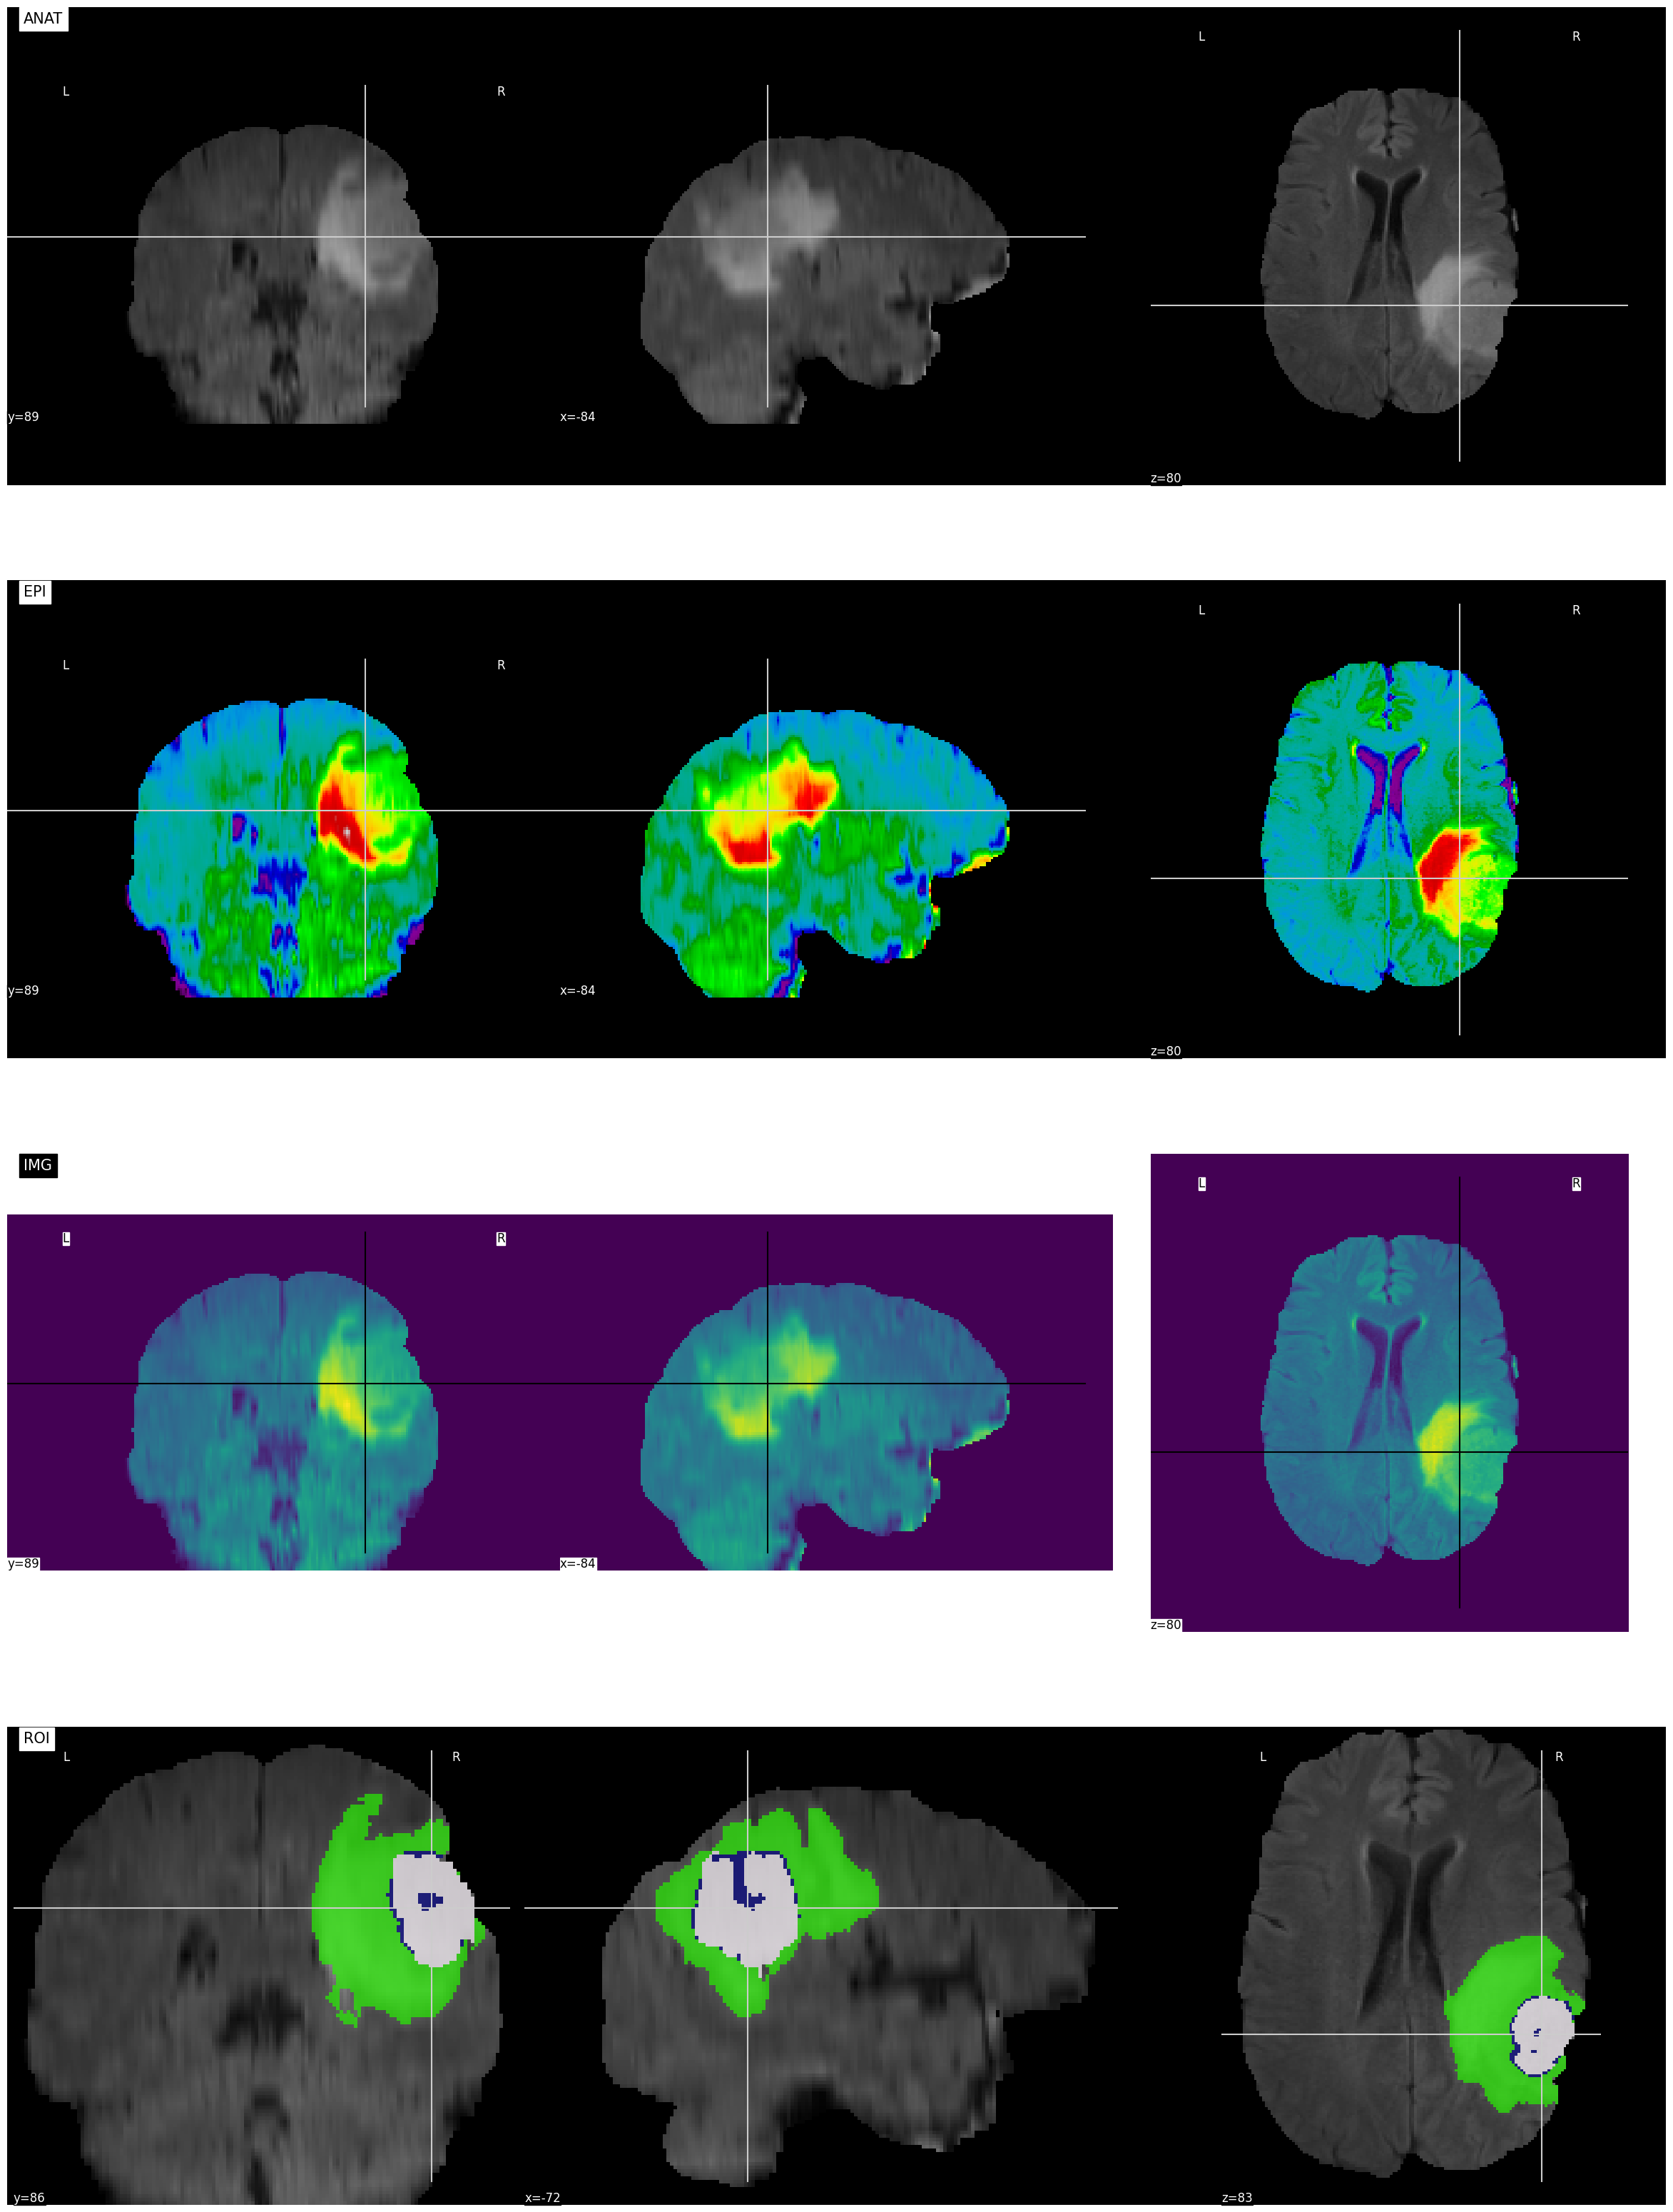

In [ ]:
def show_mri_diagram():
    image = nilearn.image.load_img(LIST_DATA[0])
    mask = nilearn.image.load_img(LIST_DATA[1])
    fig, axes = plt.subplots(nrows=4, figsize=(30, 40))
    nlplt.plot_anat(image, title='ANAT', axes=axes[0])
    nlplt.plot_epi(image, title='EPI', axes=axes[1])
    nlplt.plot_img(image, title='IMG', axes=axes[2])
    nlplt.plot_roi(mask, title='ROI', bg_img=image, axes=axes[3])
    plt.show()


show_mri_diagram()

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

class DataGenerator(keras.utils.Sequence):
    def __init__(self, list_IDs, dimensions=(IMG_SIZE, IMG_SIZE), batch_size=1, n_channels=2, shuffle=True):
        self.dimensions = dimensions
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        Batch_ids = [self.list_IDs[k] for k in indexes]
        X, y = self.__data_generation(Batch_ids)
        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        X = np.zeros((self.batch_size*SLICES_VOL,
                     *self.dimensions, self.n_channels))
        y = np.zeros((self.batch_size*SLICES_VOL, 240, 240))
        Y = np.zeros((self.batch_size*SLICES_VOL, *self.dimensions, 4))
        for c, i in enumerate(Batch_ids):
            base_path = i
            data = base_path.split('/')[-1]
            data_path = f'{i}/{data}_flair.nii'
            flair = nib.load(data_path).get_fdata()
            flair = scaler.fit_transform(
                flair.reshape(-1, flair.shape[-1])).reshape(flair.shape)

            base_path = i
            data = base_path.split('/')[-1]
            data_path = f'{i}/{data}_t1ce.nii'
            ce = nib.load(data_path).get_fdata()
            ce = scaler.fit_transform(
                ce.reshape(-1, ce.shape[-1])).reshape(ce.shape)

            base_path = i
            data = base_path.split('/')[-1]
            data_path = f'{i}/{data}_seg.nii'
            seg = nib.load(data_path).get_fdata()

            for j in range(SLICES_VOL):
                X[j + SLICES_VOL*c, :, :,
                    0] = cv2.resize(flair[:, :, j+VOL_START], (IMG_SIZE, IMG_SIZE))
                X[j + SLICES_VOL*c, :, :,
                    1] = cv2.resize(ce[:, :, j+VOL_START], (IMG_SIZE, IMG_SIZE))
                y[j + SLICES_VOL*c] = seg[:, :, j+VOL_START]

        y[y == 4] = 3
        mask = tf.one_hot(y, 4)
        Y = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE))
        return X / np.max(X), Y

training_generator = DataGenerator(TRAIN_LIST)
val_generator = DataGenerator(VAL_LIST)
test_generator = DataGenerator(TEST_LIST)

In [ ]:
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model

In [ ]:
# def resnet_unet():
#     BACKBONE = 'resnet50'
#     preprocess_input = sm.get_preprocessing(BACKBONE)
#     n_classes = 4
#     activation = 'softmax'
#     model = sm.Unet(BACKBONE, classes=n_classes, input_shape=(IMG_SIZE, IMG_SIZE, 2), activation=activation, encoder_weights=None, encoder_freeze=True)
#     return model

In [ ]:
def EfficientNet_unet():
    BACKBONE = 'efficientnetb0'
    preprocess_input = sm.get_preprocessing(BACKBONE)
    n_classes = 4
    activation = 'softmax'
    model = sm.Unet(BACKBONE, classes=n_classes, input_shape=(IMG_SIZE, IMG_SIZE, 2), activation=activation, encoder_weights=None, encoder_freeze=True)
    return model

In [ ]:
optim = tf.optimizers.Adam(0.001)
total_loss = sm.losses.categorical_focal_dice_loss
print("EfficientNet")
model = EfficientNet_unet()
model.compile(loss=total_loss, optimizer=optim, metrics=['accuracy', tf.keras.metrics.MeanIoU(
        num_classes=4), sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)])

EfficientNet


/opt/conda/lib/python3.10/site-packages/keras_applications/imagenet_utils.py:276: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 2 input channels.
  warnings.warn(


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 2)]        0         []                            
                                                                                                  
 stem_conv (Conv2D)          (None, 64, 64, 32)           576       ['input_1[0][0]']             
                                                                                                  
 stem_bn (BatchNormalizatio  (None, 64, 64, 32)           128       ['stem_conv[0][0]']           
 n)                                                                                               
                                                                                                  
 stem_activation (Activatio  (None, 64, 64, 32)           0         ['stem_bn[0][0]']         

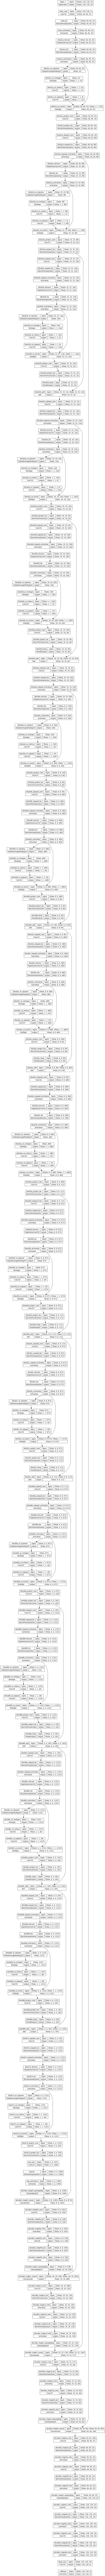

In [ ]:
plot_model(model,
           show_shapes=True,
           show_dtype=False,
           show_layer_names=True,
           rankdir='TB',
           expand_nested=False,
           dpi=70)

In [ ]:
# logger = CSVLogger(LOG[CURRENT_MODEL], separator=',', append=False)
# callbacks = [
#     keras.callbacks.EarlyStopping(monitor='loss', min_delta=0,
#                                   patience=5, verbose=1, mode='auto'),
#     keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
#                                       patience=5, min_lr=0.000001, verbose=1),
#     ModelCheckpoint(filepath=MODEL[CURRENT_MODEL]),
#     logger
# ]
# K.clear_session()

In [ ]:
history = model.fit(training_generator,
                        epochs=100,
                        batch_size = 32,
                        #steps_per_epoch=len(TRAIN_LIST),
                        #callbacks=callbacks,
                        validation_data=val_generator,
                        verbose=1
                        )

Epoch 1/100


2024-02-03 17:22:48.258913: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1706980979.383146     111 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


56/56 [==============================] - 135s 2s/step - loss: 0.7422 - accuracy: 0.9245 - mean_io_u: 0.3756 - iou_score: 0.2639 - f1-score: 0.3042 - val_loss: 0.7771 - val_accuracy: 0.9838 - val_mean_io_u: 0.3756 - val_iou_score: 0.2584 - val_f1-score: 0.2604
Epoch 2/100
56/56 [==============================] - 48s 850ms/step - loss: 0.5849 - accuracy: 0.9837 - mean_io_u: 0.3756 - iou_score: 0.3792 - f1-score: 0.4435 - val_loss: 0.7499 - val_accuracy: 0.9838 - val_mean_io_u: 0.3756 - val_iou_score: 0.2584 - val_f1-score: 0.2604
Epoch 3/100
56/56 [==============================] - 47s 845ms/step - loss: 0.5021 - accuracy: 0.9825 - mean_io_u: 0.3756 - iou_score: 0.4358 - f1-score: 0.5197 - val_loss: 0.7567 - val_accuracy: 0.9838 - val_mean_io_u: 0.3756 - val_iou_score: 0.2584 - val_f1-score: 0.2604
Epoch 4/100
56/56 [==============================] - 47s 841ms/step - loss: 0.4730 - accuracy: 0.9862 - mean_io_u: 0.3757 - iou_score: 0.4522 - f1-score: 0.5424 - val_loss: 0.7527 - val_accura

In [ ]:
def prepare_data_to_predict(path):
    base_path = path
    X = np.empty((SLICES_VOL, IMG_SIZE, IMG_SIZE, 2))
    data = base_path.split('/')[-1]
    data_path = f'{path}/{data}_flair.nii'
    data_path2 = f'{path}/{data}_t1ce.nii'
    data_path3 = f'{path}/{data}_seg.nii'
    flair = nib.load(data_path).get_fdata()
    mask = nib.load(data_path3).get_fdata()
    ce = nib.load(data_path2).get_fdata()
    for j in range(SLICES_VOL):
        X[j, :, :, 0] = cv2.resize(
            flair[:, :, j + VOL_START], (IMG_SIZE, IMG_SIZE))
        X[j, :, :, 1] = cv2.resize(
            ce[:, :, j + VOL_START], (IMG_SIZE, IMG_SIZE))
    return X, flair, mask

4/4 [==============================] - 6s 511ms/step


<Figure size 1800x5000 with 0 Axes>

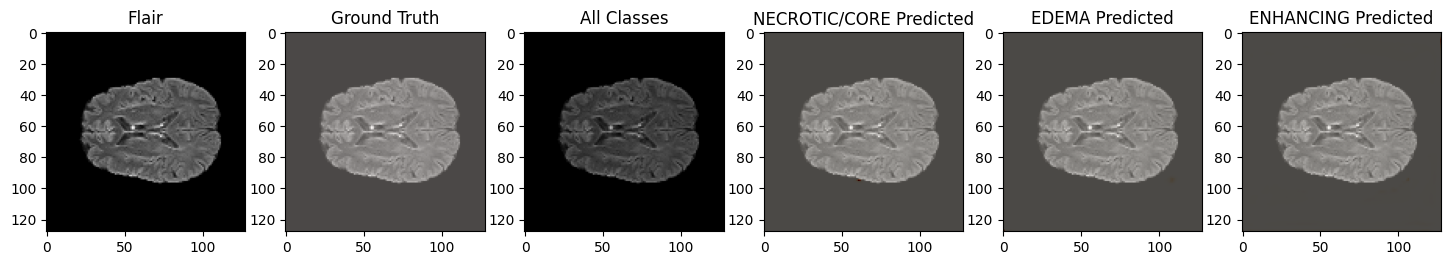

4/4 [==============================] - 0s 26ms/step


<Figure size 1800x5000 with 0 Axes>

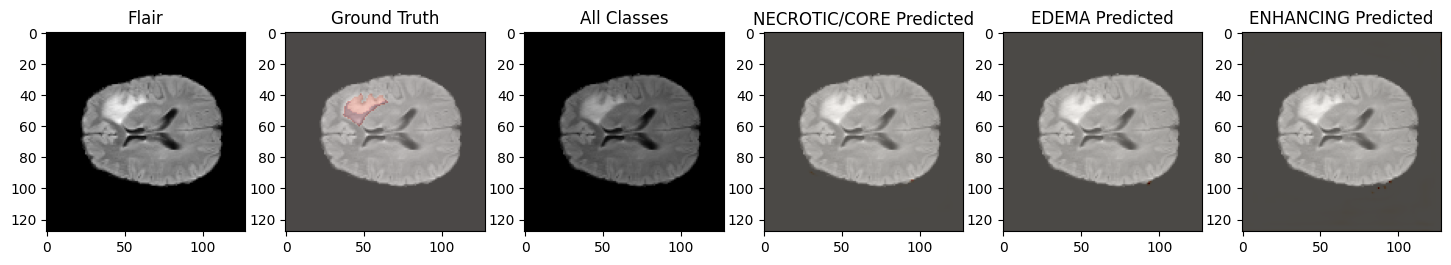

4/4 [==============================] - 0s 26ms/step


<Figure size 1800x5000 with 0 Axes>

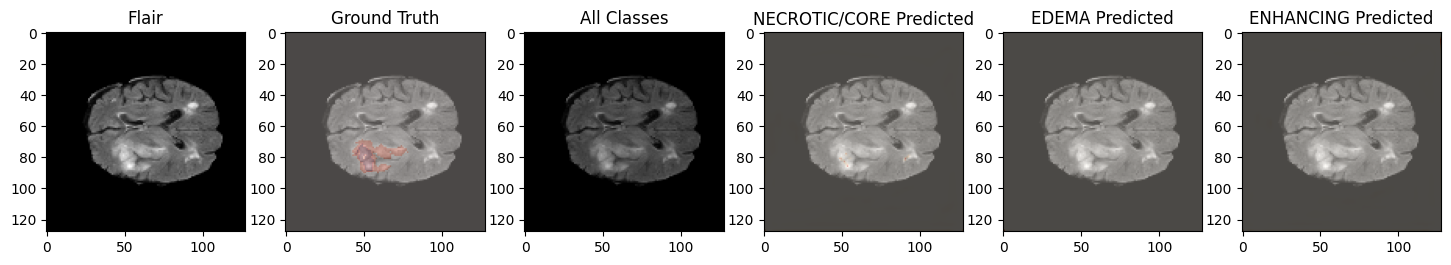

4/4 [==============================] - 0s 27ms/step


<Figure size 1800x5000 with 0 Axes>

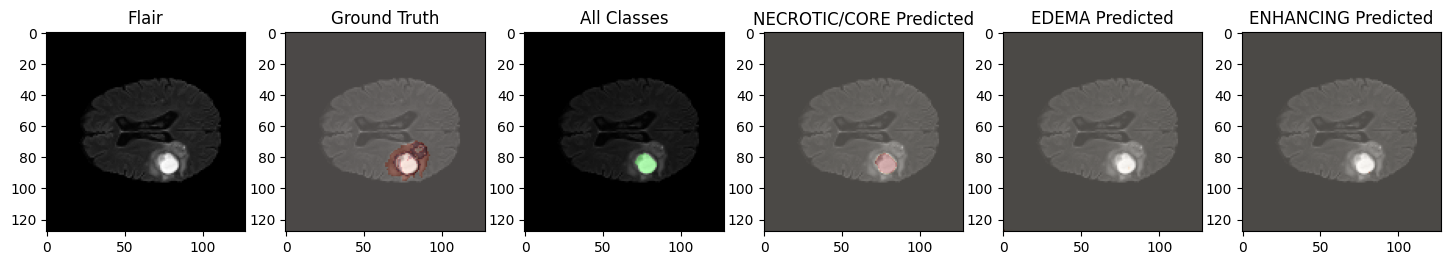

4/4 [==============================] - 0s 26ms/step


<Figure size 1800x5000 with 0 Axes>

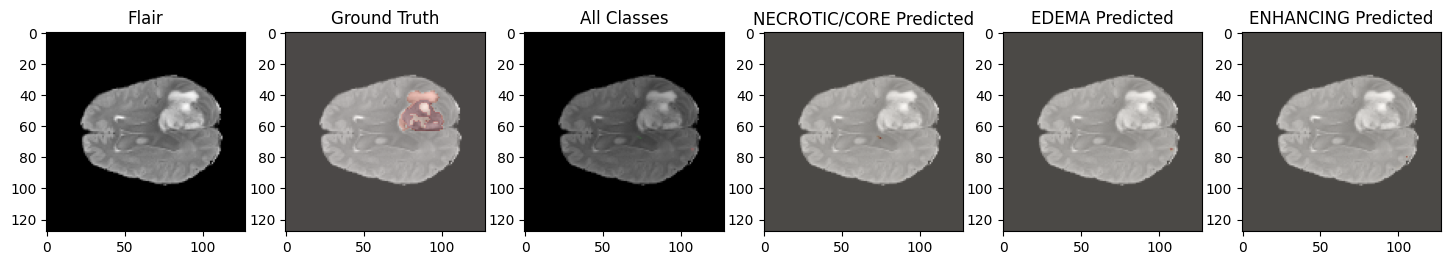

In [ ]:
slice = 60


def view_predicted_data(index):
    data, image, gt = prepare_data_to_predict(TEST_LIST[index])
    p = model.predict(data/np.max(data), verbose=1)
    core = p[:, :, :, 1]
    edema = p[:, :, :, 2]
    enhancing = p[:, :, :, 3]
    plt.figure(figsize=(18, 50))
    f, axis_arr = plt.subplots(1, 6, figsize=(18, 50))
    for i in range(6):
        axis_arr[i].imshow(cv2.resize(image[:, :, slice + VOL_START],
                                      (IMG_SIZE, IMG_SIZE)), cmap="gray")

    axis_arr[0].imshow(cv2.resize(image[:, :, slice +
                                        VOL_START], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    axis_arr[0].title.set_text('Flair')
    curr_gt = cv2.resize(gt[:, :, slice + VOL_START],
                         (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)
    axis_arr[1].imshow(curr_gt, cmap="Reds", alpha=0.3)
    axis_arr[1].title.set_text('Ground Truth')
    axis_arr[2].imshow(p[slice, :, :, 1:4], cmap="Reds", alpha=0.3)
    axis_arr[2].title.set_text('All Classes')
    axis_arr[3].imshow(edema[slice, :, :], cmap="OrRd", alpha=0.3)
    axis_arr[3].title.set_text(f'{SEGMENT_CLASSES[1]} Predicted')
    axis_arr[4].imshow(core[slice, :, ], cmap="OrRd", alpha=0.3)
    axis_arr[4].title.set_text(f'{SEGMENT_CLASSES[2]} Predicted')
    axis_arr[5].imshow(enhancing[slice, :, ], cmap="OrRd", alpha=0.3)
    axis_arr[5].title.set_text(f'{SEGMENT_CLASSES[3]} Predicted')
    plt.show()


random_index = random.sample(range(len(TEST_LIST)), 5)
for i in random_index:
    view_predicted_data(i)

4/4 [==============================] - 0s 26ms/step


<Figure size 640x480 with 0 Axes>

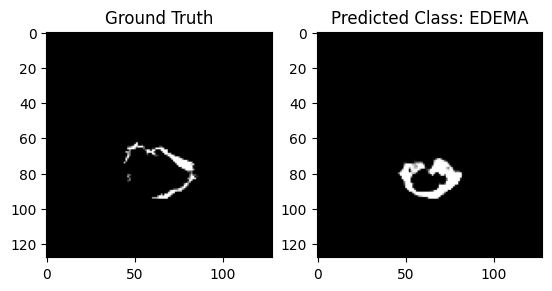

In [ ]:
path = random_index[-3]
base_path = TEST_LIST[path]
data, x, gt = prepare_data_to_predict(base_path)
p = model.predict(data/np.max(data), verbose=1)
core = p[:,:,:,1]
edema= p[:,:,:,2]
enhancing = p[:,:,:,3]
i = 40
eval_class = 2
gt[gt != eval_class] = 1
resized_gt = cv2.resize(gt[:,:,i + VOL_START], (IMG_SIZE, IMG_SIZE))
plt.figure()
f, axarr = plt.subplots(1,2)
axarr[0].imshow(resized_gt, cmap="gray")
axarr[0].title.set_text('Ground Truth')
axarr[1].imshow(p[i,:,:,eval_class], cmap="gray")
axarr[1].title.set_text(f'Predicted Class: {SEGMENT_CLASSES[eval_class]}')
plt.show()

In [ ]:
# total_loss = sm.losses.categorical_focal_dice_loss
# model.compile(loss=total_loss, optimizer=optim, metrics=['accuracy', tf.keras.metrics.MeanIoU(
#     num_classes=4), sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)])
print("Evaluation on Test Data")
results = model.evaluate(test_generator, batch_size=32)
print("Test Loss, Test Acc:", results)

Evaluation on Test Data
24/24 [==============================] - 27s 1s/step - loss: 0.4963 - accuracy: 0.9900 - mean_io_u: 0.9623 - iou_score: 0.4278 - f1-score: 0.5118
Test Loss, Test Acc: [0.49633997678756714, 0.9899516701698303, 0.9622858762741089, 0.42778265476226807, 0.5118430256843567]


In [ ]:
history

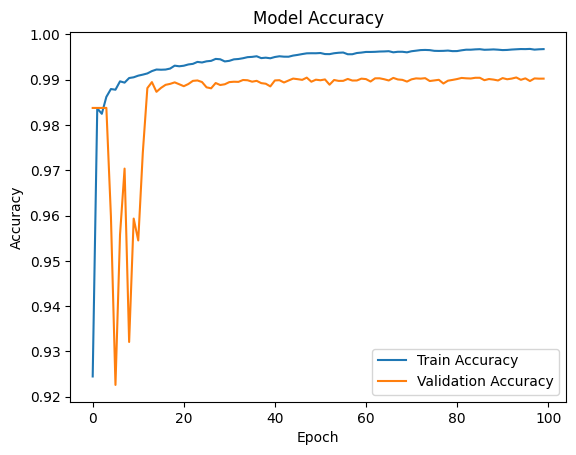

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train Accuracy', 'Validation Accuracy'], loc='lower right')
plt.show()

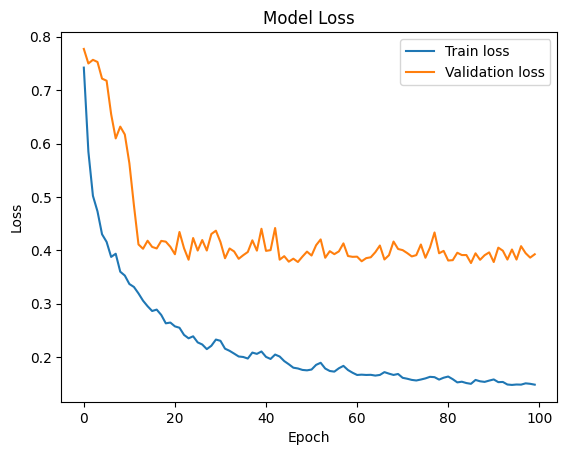

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train loss', 'Validation loss'], loc='upper right')
plt.show()

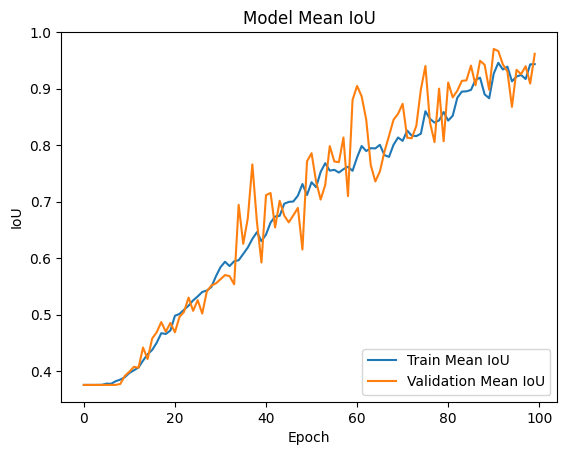

In [ ]:
plt.plot(history.history['mean_io_u'])
plt.plot(history.history['val_mean_io_u'])
plt.title('Model Mean IoU')
plt.ylabel('IoU')
plt.xlabel('Epoch')
plt.legend(['Train Mean IoU', 'Validation Mean IoU'], loc='lower right')
plt.show()

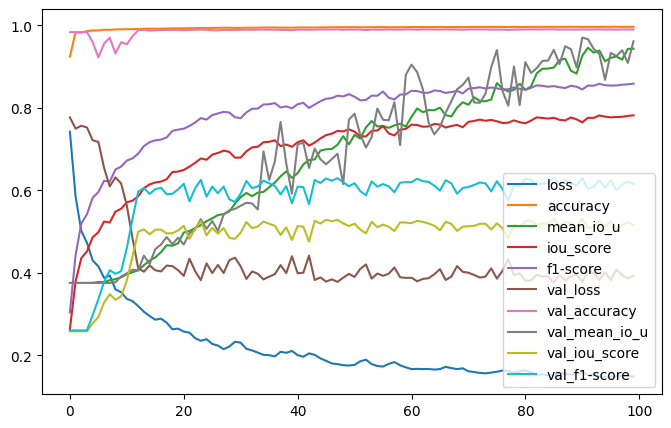

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()